In [15]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd

data = pd.read_csv('/Users/baby_cow/Desktop/AI/ML_competition/data/geocoded_addresses_12.csv')
data.columns

Index(['Unnamed: 0', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '거래유형', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-135㎡초과', '건축면적', '주차대수', 'target', 'is_test', 'latitude',
       'longitude', 'address', 'address_apt', 'address_apt_sqm', '구', '동',
       '강남여부', 'mean_target', 'apt_mean_target', 'address_mean_target',
       'mean_target_gu_dong', 'closest_bus_stop_distance',
       'closest_subway_station_distance', 'bus_stop_count_500m',
       'subway_station_count_500m', 'bus_stop_count_750m',
       'subway_station_count_750m', 'bus_stop_count_1000m',
       'subway_station_count_1000m', 'square_meter',
       'monthly_mean_target_rate', 'adjusted_square_meter', 'is_outlier',
       'year', 'month', 'distance_to_lead_house'],
      dtype='object')

In [17]:
temp_index = list(range(len(data)))
data['id'] = temp_index
selected_columns = ['id', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '구', '동', '건축년도', '주차대수', '강남여부',
                    'closest_bus_stop_distance','closest_subway_station_distance', 'bus_stop_count_500m',
                    'subway_station_count_500m', 'bus_stop_count_750m',
                    'subway_station_count_750m', 'bus_stop_count_1000m',
                    'subway_station_count_1000m', 'distance_to_lead_house', 'is_test', 'target']

df = data[selected_columns]

df['전용면적'] = df['전용면적(㎡)']
df.drop(columns=['전용면적(㎡)'], axis=1, inplace=True)

df['계약년'] = df['계약년월'].map(lambda x : int(str(x)[:4]))


# 지역별 chunk 나누기

In [18]:
chunks = {}

regions = df['구'].unique()

for region in regions:
    chunk = df[df['구'] == region]
    chunk.sort_values(by='계약년월')
    chunks[region] = chunk

# mean_target 과 apt_mean_target 만들기

In [19]:
for region in regions:
    chunk = chunks[region]
    region_mean_target = chunk.loc[chunk['is_test']==0, 'target'].mean()
    chunk.loc[chunk['is_test']==0, '지역 전년 평균'] = region_mean_target

    for apart_name in chunk['아파트명'].unique():
        apt_mean_target = chunk.loc[(chunk['is_test']==0) & (chunk['아파트명']==apart_name), 'target'].mean()
        chunk.loc[(chunk['is_test']==0) & (chunk['아파트명']==apart_name), '아파트 전년 평균'] = apt_mean_target

        for size in chunk.loc[(chunk['아파트명'] == apart_name), '전용면적'].unique():
            house_mean_target =  chunk.loc[(chunk['is_test']==0) & (chunk['아파트명']==apart_name) & (chunk['전용면적'] ==  size), 'target'].mean()
            chunk.loc[(chunk['is_test']==0) & (chunk['아파트명']==apart_name) & (chunk['전용면적'] ==  size), '가구 전년 평균'] = house_mean_target
    
    chunks[region] = chunk

# 올해 + 1년 전 우리 구 평균 부동산 가격 피쳐 만들기

In [20]:
from IPython.display import display

for region in regions:
    chunk = chunks[region]

    year_target_means = {}

    for year in range(2007, 2024):
        this_year_target_mean = chunk.loc[(chunk['계약년'] == year) & (chunk['is_test'] == 0) ,'target'].mean()
        chunk.loc[(chunk['계약년'] == year) , '올해 지역 평균'] =  this_year_target_mean
        year_target_means[year] = this_year_target_mean

        if year == 2007:
            chunk.loc[(chunk['계약년'] == year), '작년 지역 평균'] = this_year_target_mean
        else:
            chunk.loc[(chunk['계약년'] == year), '작년 지역 평균'] = year_target_means[year-1]
    
    chunks[region] = chunk

# 모델 학습

In [36]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

result_board = []
result = pd.DataFrame()
trained_models = {}

params = {
    'objective': 'regression', 
    'metric': 'rmse',           
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'lambda_l2' : 0.1,
    'drop_rate' : 0.2,
    'verbose' : -1
}

for region in tqdm(regions):
    chunk = chunks[region]

    select_cols = ['id','층', '건축년도', '주차대수', '강남여부',
        'closest_bus_stop_distance', 'closest_subway_station_distance',
        'bus_stop_count_500m', 'subway_station_count_500m',
        'bus_stop_count_750m', 'subway_station_count_750m',
        'bus_stop_count_1000m', 'subway_station_count_1000m',
        'distance_to_lead_house', 'is_test', 'target', '전용면적', '계약년',
        '올해 지역 평균', '작년 지역 평균', '지역 전년 평균', '아파트 전년 평균', '가구 전년 평균']
    
    chunk = chunk[select_cols]

    train_chunk = chunk.query('is_test == 0')
    test_chunk = chunk.query('is_test == 1')

    train_chunk.drop(columns=['is_test', 'id'], axis=1, inplace = True)
    test_chunk.drop(columns = ['is_test'], axis = 1, inplace = True)

    X = train_chunk.drop(columns=['target'], axis=1)
    y = train_chunk['target']

    tscv = TimeSeriesSplit(n_splits = 17)
    
    min_rmse = int(1e9)

    model = None
    for fold, (train_index, val_index) in enumerate(tscv.split(X), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        train_data = lgb.Dataset(X_train, label = y_train)
        val_data = lgb.Dataset(X_val, label = y_val, reference = train_data)

        if model :
            model = lgb.train(
                params,
                train_data,
                num_boost_round=5000,
                init_model = model,
                valid_sets = [train_data, val_data],
                callbacks = [lgb.early_stopping(stopping_rounds=5), lgb.log_evaluation(period=-1)],
            )
        else:
            model = lgb.train(
                params,
                train_data,
                num_boost_round=5000,
                valid_sets = [train_data, val_data],
                callbacks = [lgb.early_stopping(stopping_rounds=5), lgb.log_evaluation(period=-1)],
            )
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        min_rmse = min(min_rmse, rmse)

    result_board.append({"지역" : region, "validation RMSE" : min_rmse})

    final_train_data = lgb.Dataset(X, label=y)
    final_model = lgb.train(params,
                            final_train_data,
                            init_model = model,
                            num_boost_round=model.best_iteration,
                            callbacks = [lgb.log_evaluation(period=-1)],
                            )
    
    trained_models[region] = final_model

    test_X = test_chunk.drop(columns=['id', 'target'], axis=1)
    pred = final_model.predict(test_X)

    test_chunk['target'] = pred

    result = pd.concat([result, test_chunk[['id', 'target']]]) 


  0%|          | 0/25 [00:00<?, ?it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[330]	training's rmse: 13140.5	valid_1's rmse: 43730.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[545]	training's rmse: 12809.2	valid_1's rmse: 14639.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[781]	training's rmse: 11235.9	valid_1's rmse: 48721.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[921]	training's rmse: 14018.9	valid_1's rmse: 41368.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1177]	training's rmse: 15947.6	valid_1's rmse: 24927.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1207]	training's rmse: 17026.8	valid_1's rmse: 24622.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[13

  4%|▍         | 1/25 [03:33<1:25:26, 213.59s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[170]	training's rmse: 6903.61	valid_1's rmse: 15936.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[631]	training's rmse: 4075.09	valid_1's rmse: 7717.08
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[669]	training's rmse: 4749.17	valid_1's rmse: 15545.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1040]	training's rmse: 4251.08	valid_1's rmse: 29004.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1139]	training's rmse: 7430.26	valid_1's rmse: 11141.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1212]	training's rmse: 6736.82	valid_1's rmse: 7676.78
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1

  8%|▊         | 2/25 [06:37<1:15:13, 196.23s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[621]	training's rmse: 2554.09	valid_1's rmse: 6285.09
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1051]	training's rmse: 2464.79	valid_1's rmse: 3112.91
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1052]	training's rmse: 2690.89	valid_1's rmse: 23798.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1277]	training's rmse: 3283.48	valid_1's rmse: 8352.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1284]	training's rmse: 4612.18	valid_1's rmse: 9752.01
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1597]	training's rmse: 3527.4	valid_1's rmse: 6053.36
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1

 12%|█▏        | 3/25 [08:44<1:00:24, 164.74s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[489]	training's rmse: 3820.75	valid_1's rmse: 10627.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[737]	training's rmse: 3687.98	valid_1's rmse: 5497.32
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[738]	training's rmse: 4359.71	valid_1's rmse: 25821.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[935]	training's rmse: 5017.77	valid_1's rmse: 8452.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[997]	training's rmse: 5354.84	valid_1's rmse: 7883.47
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1021]	training's rmse: 5591.94	valid_1's rmse: 7288.67
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1022

 16%|█▌        | 4/25 [12:38<1:07:09, 191.87s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[281]	training's rmse: 3492.08	valid_1's rmse: 8189.47
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[634]	training's rmse: 2953.21	valid_1's rmse: 3763.92
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[636]	training's rmse: 3233.82	valid_1's rmse: 28153.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[848]	training's rmse: 4218.38	valid_1's rmse: 8478.69
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1036]	training's rmse: 4136.29	valid_1's rmse: 10325.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1111]	training's rmse: 4584	valid_1's rmse: 6752.69
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1144]

 20%|██        | 5/25 [15:25<1:00:56, 182.85s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[405]	training's rmse: 5453.56	valid_1's rmse: 17211.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[747]	training's rmse: 5318.31	valid_1's rmse: 7678.83
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[764]	training's rmse: 5999.23	valid_1's rmse: 34354.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[977]	training's rmse: 7504.23	valid_1's rmse: 18279.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1095]	training's rmse: 8194.66	valid_1's rmse: 17402.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1112]	training's rmse: 9732.4	valid_1's rmse: 13150.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[122

 24%|██▍       | 6/25 [17:48<53:38, 169.40s/it]  

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[373]	training's rmse: 2685.89	valid_1's rmse: 9141.11
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[559]	training's rmse: 3197.95	valid_1's rmse: 5310.63
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[936]	training's rmse: 2709.02	valid_1's rmse: 17055.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1139]	training's rmse: 3640.87	valid_1's rmse: 8064.47
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1296]	training's rmse: 3862.93	valid_1's rmse: 7531.43
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1422]	training's rmse: 3925.67	valid_1's rmse: 6820.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[14

 28%|██▊       | 7/25 [22:11<59:59, 200.00s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[309]	training's rmse: 2230.9	valid_1's rmse: 6787.15
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[544]	training's rmse: 1901.58	valid_1's rmse: 9714.34
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1071]	training's rmse: 2082.42	valid_1's rmse: 17215.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1232]	training's rmse: 3497	valid_1's rmse: 7386.26
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1282]	training's rmse: 3905.42	valid_1's rmse: 6893.36
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1347]	training's rmse: 3839.83	valid_1's rmse: 3608.46
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1348

 32%|███▏      | 8/25 [23:48<47:23, 167.26s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[525]	training's rmse: 2349.26	valid_1's rmse: 7230.19
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[696]	training's rmse: 2606.26	valid_1's rmse: 3419.79
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[744]	training's rmse: 2667.66	valid_1's rmse: 27165.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[960]	training's rmse: 3803.28	valid_1's rmse: 8766.82
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1033]	training's rmse: 4177.94	valid_1's rmse: 8584.12
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1076]	training's rmse: 4593.22	valid_1's rmse: 3453.81
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[11

 36%|███▌      | 9/25 [28:23<53:36, 201.02s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[238]	training's rmse: 2558.8	valid_1's rmse: 6717.13
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[757]	training's rmse: 2092.86	valid_1's rmse: 4944.82
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1199]	training's rmse: 2170.39	valid_1's rmse: 12822.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1318]	training's rmse: 3806.57	valid_1's rmse: 8145.51
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1355]	training's rmse: 4439.66	valid_1's rmse: 6181.17
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1432]	training's rmse: 4116.38	valid_1's rmse: 3678.07
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1

 40%|████      | 10/25 [31:38<49:45, 199.00s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[403]	training's rmse: 4003.25	valid_1's rmse: 7602.12
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[698]	training's rmse: 3457.55	valid_1's rmse: 5301.52
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1502]	training's rmse: 2980.93	valid_1's rmse: 20334.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1751]	training's rmse: 4102.26	valid_1's rmse: 9773.41
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1907]	training's rmse: 4643.35	valid_1's rmse: 9097.15
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1995]	training's rmse: 4881.04	valid_1's rmse: 6848.36
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[

 44%|████▍     | 11/25 [34:53<46:10, 197.91s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[351]	training's rmse: 5123.1	valid_1's rmse: 12505.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[990]	training's rmse: 4430.11	valid_1's rmse: 5932.29
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1256]	training's rmse: 4378.17	valid_1's rmse: 39533.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1444]	training's rmse: 6808.43	valid_1's rmse: 12959.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1510]	training's rmse: 7243.48	valid_1's rmse: 10519.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1516]	training's rmse: 7770.96	valid_1's rmse: 7495.91
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1

 48%|████▊     | 12/25 [38:25<43:46, 202.00s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[402]	training's rmse: 6195.22	valid_1's rmse: 13271.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[676]	training's rmse: 6060.89	valid_1's rmse: 6445.32
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[691]	training's rmse: 6044.35	valid_1's rmse: 35577.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[905]	training's rmse: 7504.61	valid_1's rmse: 13174.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1622]	training's rmse: 6332.31	valid_1's rmse: 11532.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1800]	training's rmse: 6539.26	valid_1's rmse: 10275.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[19

 52%|█████▏    | 13/25 [42:26<42:46, 213.83s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[536]	training's rmse: 4894.93	valid_1's rmse: 8137.64
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[926]	training's rmse: 4091.08	valid_1's rmse: 6051.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1464]	training's rmse: 3640.6	valid_1's rmse: 21372.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1609]	training's rmse: 5634.27	valid_1's rmse: 10548.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1739]	training's rmse: 5589.41	valid_1's rmse: 8812.31
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1771]	training's rmse: 5946.29	valid_1's rmse: 7469.62
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[18

 56%|█████▌    | 14/25 [46:08<39:38, 216.23s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[239]	training's rmse: 14627.6	valid_1's rmse: 39304.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[740]	training's rmse: 10476	valid_1's rmse: 14704.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[787]	training's rmse: 11155.4	valid_1's rmse: 65005.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[887]	training's rmse: 17624	valid_1's rmse: 31001.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1038]	training's rmse: 15861.6	valid_1's rmse: 27189.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1124]	training's rmse: 15901.6	valid_1's rmse: 18331.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1125]	

 60%|██████    | 15/25 [49:47<36:12, 217.25s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[617]	training's rmse: 6939.21	valid_1's rmse: 14846.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[996]	training's rmse: 5810.94	valid_1's rmse: 5834.88
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1048]	training's rmse: 5508.84	valid_1's rmse: 55557.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1212]	training's rmse: 12051.5	valid_1's rmse: 17809.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1376]	training's rmse: 10884.1	valid_1's rmse: 16121.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1435]	training's rmse: 10979.1	valid_1's rmse: 10865.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[

 64%|██████▍   | 16/25 [53:00<31:28, 209.82s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[397]	training's rmse: 3761.27	valid_1's rmse: 6883.11
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[583]	training's rmse: 3558.03	valid_1's rmse: 4750.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[765]	training's rmse: 3402.76	valid_1's rmse: 27259.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[957]	training's rmse: 4563.51	valid_1's rmse: 9606.15
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1056]	training's rmse: 4730.24	valid_1's rmse: 10638.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1162]	training's rmse: 4906.7	valid_1's rmse: 7381.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1336]

 68%|██████▊   | 17/25 [56:45<28:35, 214.40s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[283]	training's rmse: 7713.68	valid_1's rmse: 26203.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[665]	training's rmse: 6370.49	valid_1's rmse: 10241.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1160]	training's rmse: 5697.51	valid_1's rmse: 21772.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1480]	training's rmse: 6380.01	valid_1's rmse: 34663.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1580]	training's rmse: 10069.7	valid_1's rmse: 14436.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1612]	training's rmse: 10060.1	valid_1's rmse: 11314.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[

 72%|███████▏  | 18/25 [1:02:25<29:25, 252.26s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[214]	training's rmse: 7140.37	valid_1's rmse: 14493.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[649]	training's rmse: 4578.09	valid_1's rmse: 7808.97
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[731]	training's rmse: 5058.32	valid_1's rmse: 18121.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1150]	training's rmse: 4860.03	valid_1's rmse: 26272.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1258]	training's rmse: 7041.9	valid_1's rmse: 12267.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1303]	training's rmse: 7171	valid_1's rmse: 9888.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1306]	

 76%|███████▌  | 19/25 [1:06:37<25:12, 252.16s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[712]	training's rmse: 4170.73	valid_1's rmse: 13569.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1073]	training's rmse: 4668	valid_1's rmse: 7434.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1226]	training's rmse: 4733.02	valid_1's rmse: 36963.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1428]	training's rmse: 6697.53	valid_1's rmse: 12889.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1745]	training's rmse: 6281.42	valid_1's rmse: 11377
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1866]	training's rmse: 6312.98	valid_1's rmse: 10396.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1869]

 80%|████████  | 20/25 [1:11:28<21:58, 263.74s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[355]	training's rmse: 9357.78	valid_1's rmse: 77881.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[651]	training's rmse: 10821.5	valid_1's rmse: 17708.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[970]	training's rmse: 9090.77	valid_1's rmse: 82184.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1044]	training's rmse: 24300	valid_1's rmse: 35578.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1235]	training's rmse: 17503.4	valid_1's rmse: 23840.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1367]	training's rmse: 15519.2	valid_1's rmse: 16891.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[141

 84%|████████▍ | 21/25 [1:14:06<15:28, 232.06s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[340]	training's rmse: 3177.54	valid_1's rmse: 8677.94
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[562]	training's rmse: 3421.71	valid_1's rmse: 5785.03
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[769]	training's rmse: 3208.54	valid_1's rmse: 21677.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[972]	training's rmse: 4537.89	valid_1's rmse: 9013.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1094]	training's rmse: 4864.88	valid_1's rmse: 9643.59
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1201]	training's rmse: 4879.4	valid_1's rmse: 9776.81
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1202

 88%|████████▊ | 22/25 [1:17:51<11:29, 229.78s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[349]	training's rmse: 5038.11	valid_1's rmse: 11787.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[788]	training's rmse: 4896.66	valid_1's rmse: 10876
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[906]	training's rmse: 5859.43	valid_1's rmse: 28088.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1112]	training's rmse: 7254.66	valid_1's rmse: 16007.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1670]	training's rmse: 6518.42	valid_1's rmse: 13317.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2033]	training's rmse: 5670.84	valid_1's rmse: 11676.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[217

 92%|█████████▏| 23/25 [1:19:29<06:21, 190.53s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[404]	training's rmse: 4569.16	valid_1's rmse: 13963.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[731]	training's rmse: 5745.54	valid_1's rmse: 10802.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3830]	training's rmse: 3425.45	valid_1's rmse: 30725.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4205]	training's rmse: 6334.1	valid_1's rmse: 12734
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4717]	training's rmse: 5951.62	valid_1's rmse: 18223.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[5270]	training's rmse: 5641.53	valid_1's rmse: 9417.05
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[535

 96%|█████████▌| 24/25 [1:25:30<04:01, 241.56s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[548]	training's rmse: 2641.15	valid_1's rmse: 5144.99
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[730]	training's rmse: 2476.17	valid_1's rmse: 7533.68
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1172]	training's rmse: 2337.69	valid_1's rmse: 14254.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1316]	training's rmse: 3788.67	valid_1's rmse: 6502.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1355]	training's rmse: 4105.05	valid_1's rmse: 6281.79
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1439]	training's rmse: 3959.19	valid_1's rmse: 3869.62
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1

100%|██████████| 25/25 [1:30:11<00:00, 216.47s/it]


# 결과 확인

In [37]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # MacOS의 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False   # 마이너스 기호 깨짐 방지

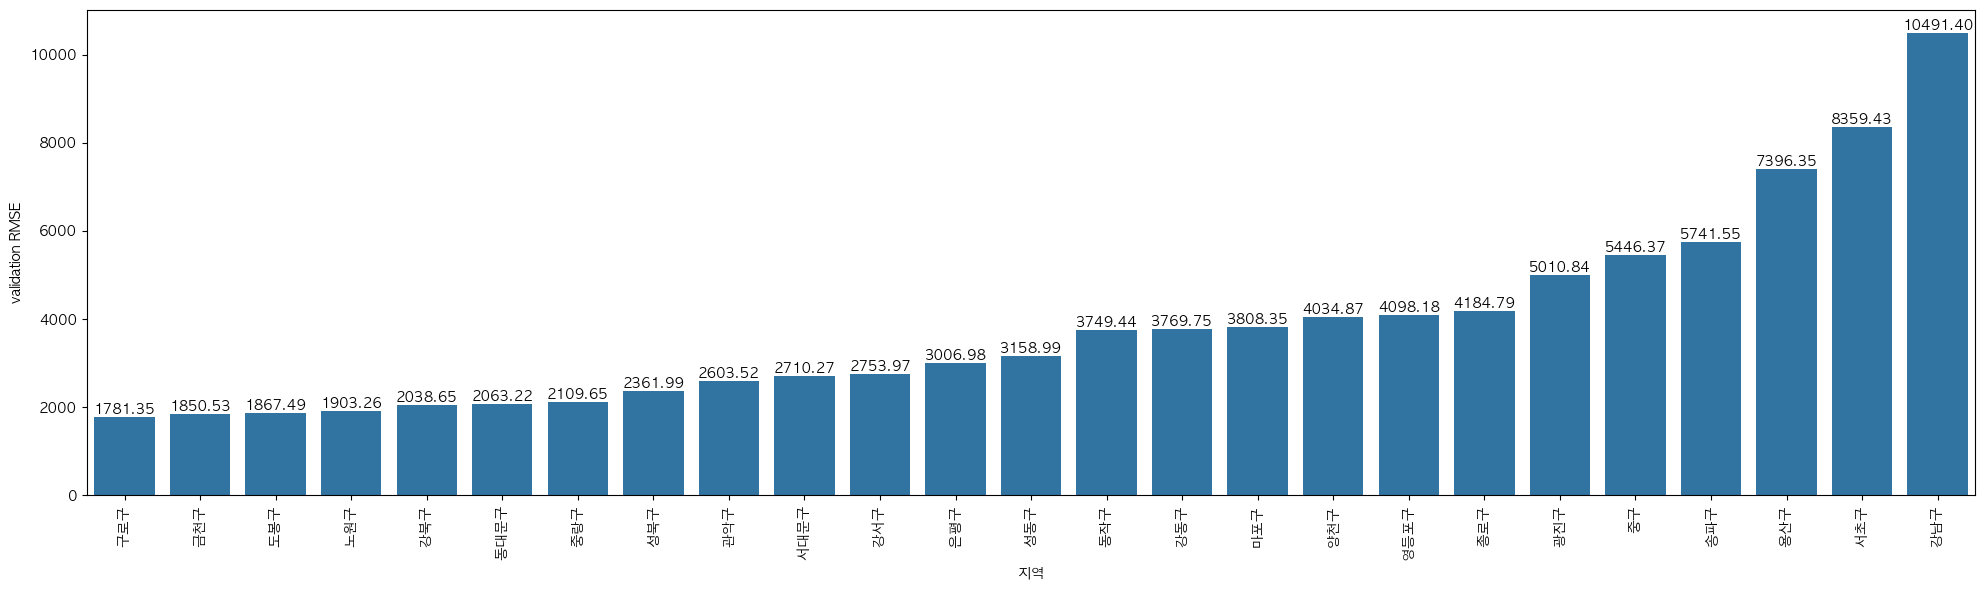

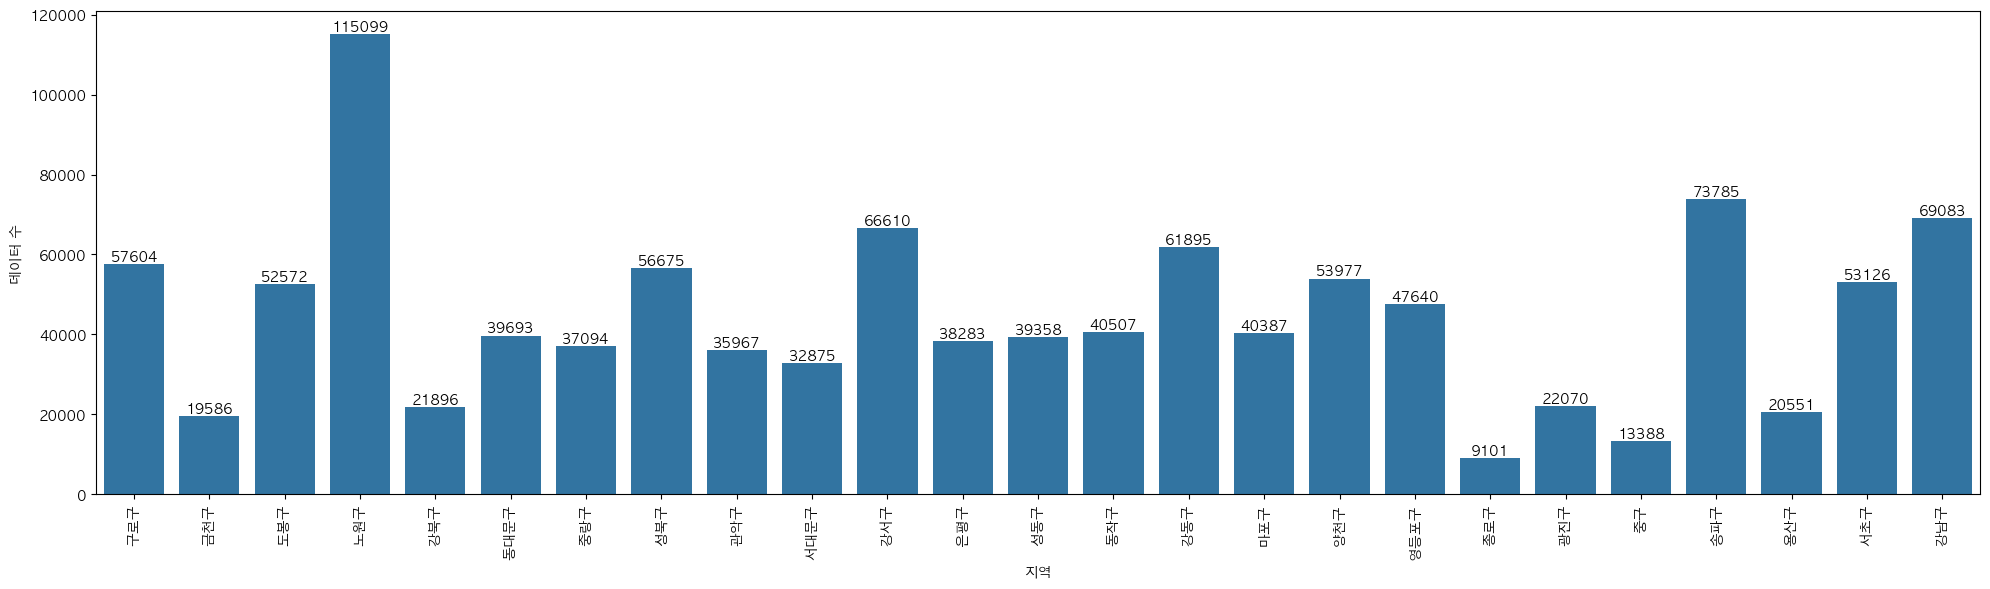

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

result_df = pd.DataFrame(result_board)
result_df = result_df.sort_values(by='validation RMSE')
result_df = result_df[-30:]

# 그래프 생성
plt.figure(figsize=(20, 6))
ax = sns.barplot(data=result_df, x='지역', y='validation RMSE')

# 바 위에 값 표시
for i, v in enumerate(result_df['validation RMSE']):
    ax.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()


temp_list = [{"지역" : region, "데이터 수" : len(chunks[region].query("is_test == 0"))} for region in result_df['지역']]
temp_df = pd.DataFrame(temp_list)

plt.figure(figsize=(20, 6))
ax = sns.barplot(data = temp_df, x='지역', y='데이터 수')

# 바 위에 값 표시
for i, v in enumerate(temp_df['데이터 수']):
    ax.text(i, v, f'{v}', ha='center', va='bottom')

plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

In [39]:
submit = result.sort_values(by = 'id')

display(submit)
print(submit.isnull().sum())

submit['target'] = submit['target'] * 1.065
submit['target'] = submit['target'].astype(int)
submit.to_csv('region_devision_N_fixed_mean_features.csv', index=False)

,id,target
1118822,1118822,54996.101096
1118823,1118823,47465.114381
1118824,1118824,80827.489231
1118825,1118825,76283.490766
1118826,1118826,43255.270561
...,...,...
1128089,1128089,40369.587050
1128090,1128090,40617.688887
1128091,1128091,43077.801124
1128092,1128092,39068.725818


id        0
target    0
dtype: int64


# Valid dataset 결과 비교

In [40]:
total_rmse = 0
for region in regions:
    chunk = chunks[region]

    select_cols = ['id','층', '건축년도', '주차대수', '강남여부',
        'closest_bus_stop_distance', 'closest_subway_station_distance',
        'bus_stop_count_500m', 'subway_station_count_500m',
        'bus_stop_count_750m', 'subway_station_count_750m',
        'bus_stop_count_1000m', 'subway_station_count_1000m',
        'distance_to_lead_house', 'target', '전용면적', '계약년',
        '올해 지역 평균', '작년 지역 평균', '지역 전년 평균', '아파트 전년 평균', '가구 전년 평균']

    valid_data = chunk[(chunk['계약년'] == 2023) & (chunk['is_test'] == 0)]
    valid_data = valid_data[select_cols]

    X = valid_data.drop(columns = ['target', 'id'], axis=1)
    y = valid_data['target']

    model = trained_models[region]
    pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, pred))
    total_rmse += rmse

    print(f"{region} : {rmse}")

total_rmse = total_rmse / len(regions)
print(f"total rmse : {total_rmse}")
    


강남구 : 12548.6426790687
강동구 : 5333.2710155229215
강북구 : 2804.5271627218594
강서구 : 4206.647736764514
관악구 : 3553.6500932877166
광진구 : 6392.782805031828
구로구 : 3053.0783964232137
금천구 : 2657.0294883792294
노원구 : 3689.3212764570767
도봉구 : 3126.7571418310063
동대문구 : 3833.9030040086313
동작구 : 5784.932917614929
마포구 : 4997.401716382029
서대문구 : 4206.074200300373
서초구 : 11738.01773994934
성동구 : 7065.752834211044
성북구 : 3488.9659590306856
송파구 : 7485.638478778362
양천구 : 5281.210427437776
영등포구 : 5417.993917659342
용산구 : 8471.673018870917
은평구 : 4165.508833034114
종로구 : 5203.396224434374
중구 : 5995.157636992483
중랑구 : 2404.870155560432
total rmse : 5316.248194390117
